In [1]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import open3d as o3d

from src.utils.dataloader import load_ear_data
from src.utils.integrate import elementwise_dblquad, elementwise_circquad
from src.utils.viz import (set_colorblind, scatter_2d, scatter_3d,
                           colormap_from_array, save_fig, fig_config)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# utility functions

def clean_df(df):
    """Remove the points that correspond to the external surface of the
    Simulia/CST simulation domain.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Raw output Simulia/CST data.

    Returns
    -------
    pandas.DataFrame
        Electric and magnetic field components only at the ear surface.
    """
    df = df[(df['x [mm]'] != df['x [mm]'].min())
            & (df['x [mm]'] != df['x [mm]'].max())
            & (df['y [mm]'] != df['y [mm]'].min())
            & (df['y [mm]'] != df['y [mm]'].max())
            & (df['z [mm]'] != df['z [mm]'].min())
            & (df['z [mm]'] != df['z [mm]'].max())]
    df.reset_index(drop=True, inplace=True)
    return df


def export_pcd(df, area=False):
    """Convert the clean dataframe to point cloud.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Clean version of the dataframe consisting the Simulia/CST
        output data.
    area : Bool, optional
        If True, the output will have area of the finite element
        corresponding to the specific point.

    Returns
    -------
    numpy.ndarray
        Either array of shape (n, 3) where each column corresponds to
        x-, y-, and z-coordinates of the ear model, or array of shape
        (n, 4) where additional column corresponds to the area of the
        finite element corresponding to the specific point.
    """
    if area:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy(),
                    df['area [mm^2]'].to_numpy()]
    else:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy()]
    return pcd


def visualize_ear(xyz):
    """Visualize the ear model in open3d visualizer.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.

    Returns
    -------
    None
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    center = pcd.get_center()
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=9,
                                                               origin=center+np.array([6, -25, -20]))
    pcd.estimate_normals()
    radii = [0.005, 0.01, 0.02, 0.04]
    rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii))
    o3d.visualization.draw_geometries([cframe, pcd],
                                      zoom=0.69999999999999996,
                                      front=[0.92231085610160646, 0.17546582462905541, 0.34431733779228646],
                                      lookat=[71.236805645281521, 22.531933429935712, -8.12589641784127],
                                      up=[-0.16595758534247468, 0.98447554162242001, -0.057148821637356101],
                                     )


def export_fields(df):
    """Convert the clean dataframe to array of electromagnetic field
    components.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Clean version of the dataframe consisting the Simulia/CST
        output data.

    Returns
    -------
    tuple
        First element of the tuple holds the 3 arrays for 3 components
        of the electric field vector, while the second element holds
        the 3 arrays each corresponding the the 3 components of the
        magnetic field vector.
    """
    Ex = df['ExRe [V/m]'].to_numpy() + 1j * df['ExIm [V/m]'].to_numpy()
    Ey = df['EyRe [V/m]'].to_numpy() + 1j * df['EyIm [V/m]'].to_numpy()
    Ez = df['EzRe [V/m]'].to_numpy() + 1j * df['EzIm [V/m]'].to_numpy()
    Hx = df['HxRe [A/m]'].to_numpy() + 1j * df['HxIm [A/m]'].to_numpy()
    Hy = df['HyRe [A/m]'].to_numpy() + 1j * df['HyIm [A/m]'].to_numpy()
    Hz = df['HzRe [A/m]'].to_numpy() + 1j * df['HzIm [A/m]'].to_numpy()
    return (Ex, Ey, Ez), (Hx, Hy, Hz)


def poynting_vector(E, H):
    """Return power density given x-, y-, and z-component of electric
    and magnetic field. It assumes that the given components are max
    values and all components of the power dansity are scaled by 1/2.
    
    Parameters
    ----------
    E : tuple
        3 arrays for 3 components of the electric field vector.
    H : tuple
        3 arrays for 3 components of the magnetic field vector.

    Returns
    -------
    tuple
        Containg 3 arrays for 3 components of the Poynting vector.
    """
    Sx = 0.5 * (E[1] * H[2].conjugate() - E[2] * H[1].conjugate())
    Sy = 0.5 * (E[2] * H[0].conjugate() - E[0] * H[2].conjugate())
    Sz = 0.5 * (E[0] * H[1].conjugate() - E[1] * H[0].conjugate())
    return Sx, Sy, Sz


def estimate_normals(xyz, take_every=1, knn=30, fast=True):
    """Return estimated normals for a given point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    take_every : int, optional
        How many points to skip in the point cloud when estimating
        normal vectors.
    knn : int, optional
        Number of neighbors for KDTree search.
    fast : bool, optional
        If True, the normal estimation uses a non-iterative method to
        extract the eigenvector from the covariance matrix. This is
        faster, but is not as numerical stable.

    Returns
    -------
    numpy.ndarray
        The number of rows correspond to the number of rows of a given
        point cloud, and each column corresponds to each component of
        the normal vector.
    """
    import open3d as o3d
    xyz = xyz[::take_every, :]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn),
                         fast_normal_computation=fast)
    pcd.normalize_normals()
    n = np.asarray(pcd.normals)
    return n


def export_rect_idx(xyz, center, edge_length, view='xy'):
    """Extract specific points that correspond to a rectangle, defined
    with a central point and its edge length, from a point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    center : tuple or list
        z- and y-coordinate that defines the center of a desired
        rectangle.
    edge_length : float
        Edge length of a desired rectangle.
    view : string
        Point of view for point extraction. Currently supported `xy`
        and `zy`.

    Returns
    -------
    tuple
        Origin of a desired rectangle and indexes of all points from a point
        cloud that falls into a rectangle.
    """
    x_bound = [center[0] - edge_length / 2,
               center[0] + edge_length / 2]
    y_bound = [center[1] - edge_length / 2,
               center[1] + edge_length / 2]
    origin = [x_bound[0], y_bound[0]]
    if view == 'xy':
        col_idx = 0
    elif view == 'zy':
        col_idx = 2
    else:
        raise ValueError(f'Not supported view: {view}')
    idx_rect = np.where((xyz[:, col_idx] > x_bound[0])
                        & (xyz[:, col_idx] < x_bound[1])
                        & (xyz[:, 1] > y_bound[0])
                        & (xyz[:, 1] < y_bound[1]))[0]
    return origin, idx_rect


def export_circ_idx(xyz, center, radius, view='xy'):
    """Extract specific points that correspond to a disk, defined
    with a central point and its radius, from a point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    center : tuple or list
        z- and y-coordinate that defines the center of a desired
        disk.
    radius : float
        Radius of a desired disk.
    view : string
        Point of view for point extraction. Currently supported `xy`
        and `zy`.

    Returns
    -------
    numpy.ndarray
        Indexes of all points from a point cloud that falls into a
        circle describing a disk.
    """
    cx, cy = center
    if view == 'xy':
        col_idx = 0
    elif view == 'zy':
        col_idx = 2
    else:
        raise ValueError(f'Not supported view: {view}')
    idx_circ = np.where(
        (xyz[:, col_idx] - cx) ** 2 + (xyz[:, 1] - cy) ** 2 < radius ** 2)[0]
    return idx_circ


def diff_in_dB(apd1, apd2):
    """Return the difference in dB between two values for the power.
    
    Parameters
    ----------
    apd1 : float or numpy.ndarray
        Absorbed power density, or anything else measured in Watts.
    apd2 : float or numpy.ndarray
        Absorbed power density, or anything else measured in Watts to
        be compared to `apd1`.

    Returns
    -------
    float or numpy.ndarray
        Difference(s) in dB between two (arrays of) values of the
        power.
    """
    diff = np.abs(10 * np.log10(apd1 / apd2))
    return diff

In [3]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

In [4]:
PROJECT_NAME = 'IMBioC2022_paper'

In [5]:
# full dataset

df = load_ear_data('te', 26)
df = clean_df(df)
df

INFO - 2021-12-16 14:08:47,368 - utils - NumExpr defaulting to 4 threads.


,x [mm],y [mm],z [mm],ExRe [V/m],ExIm [V/m],EyRe [V/m],EyIm [V/m],EzRe [V/m],EzIm [V/m],HxRe [A/m],HxIm [A/m],HyRe [A/m],HyIm [A/m],HzRe [A/m],HzIm [A/m],area [mm^2]
0,68.082165,-2.690852,6.271268,8.432562,-2.209704,4.823269,-3.585388,-0.318288,-1.180538,0.001500,-0.037099,-0.115981,0.055472,-0.020880,0.028765,0.022861
1,68.135670,-1.863479,6.271268,9.345520,-4.404868,-0.179793,-3.936063,1.309201,-0.949423,-0.017987,-0.040067,-0.099633,0.082363,0.010157,0.005327,0.022275
2,68.135670,-1.636673,6.271268,8.266172,-4.056241,-0.958262,-3.304308,1.385371,-0.781440,-0.025019,-0.033956,-0.091856,0.089071,0.010375,-0.000468,0.022275
3,68.135670,-1.409867,6.271268,8.946388,-4.919263,-1.361357,-2.731067,1.276011,-0.795593,-0.028081,-0.025859,-0.086564,0.090241,0.008700,-0.004807,0.022275
4,68.135670,-0.956255,6.271268,8.171646,-4.761393,-1.857163,-1.358530,1.316144,-0.712282,-0.028606,-0.008264,-0.074443,0.089836,0.003226,-0.008501,0.022275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222863,79.038233,22.373952,-19.391122,66.206825,64.545242,-0.689625,-0.100447,-9.090065,5.119849,0.002356,0.001253,0.164819,0.205397,-0.004124,-0.006281,0.020444
222864,79.025510,23.046562,-19.441171,64.057335,66.411644,0.909757,1.231686,-9.339426,4.378840,-0.000114,-0.002779,0.157989,0.207011,-0.001567,-0.002598,0.019642
222865,78.999029,23.039935,-19.553220,57.784794,70.080719,0.737604,1.131206,-10.815549,1.872078,0.000070,-0.002646,0.146581,0.216925,-0.002078,-0.002558,0.018448
222866,79.018096,23.266698,-19.455409,63.259869,66.919777,1.354949,1.630377,-9.443484,4.116384,-0.000838,-0.003974,0.155768,0.207149,-0.000843,-0.001365,0.019096


In [6]:
# conversion to numpys

xyz = export_pcd(df)
E, H = export_fields(df)

In [7]:
# extracting components of the power density vector field

Sx, Sy, Sz = poynting_vector(E, H)

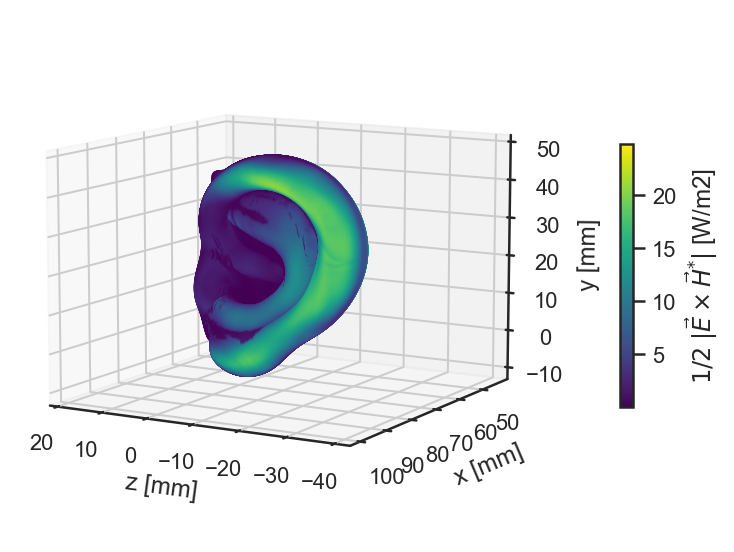

In [8]:
# visualization of the absolute value of the power density

S = abs(np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2))
S_label = r'$1/2$ $|\vec{E}\times\vec{H}^{*}|$ [W/m2]'
fig, ax = scatter_3d({'z [mm]': xyz[:, 2],
                      'x [mm]': xyz[:, 0],
                      'y [mm]': xyz[:, 1],
                       S_label: S},
                     elev=[10], azim=[120])

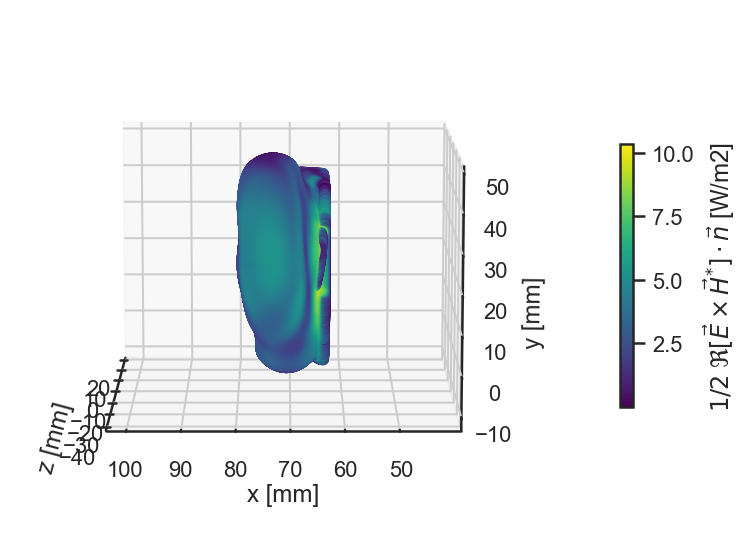

In [9]:
# visualization of the real part of the power density normal to the surface

n = estimate_normals(xyz, knn=30, fast=True)
Sr = abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])
Sr_label = r'$1/2$ $\Re{[\vec{E}\times\vec{H}^{*}]} \cdot \vec{n}$ [W/m2]'
fig, ax = scatter_3d({'z [mm]': xyz[:, 2],
                      'x [mm]': xyz[:, 0],
                      'y [mm]': xyz[:, 1],
                      Sr_label: Sr},
                      elev=[10], azim=[180])

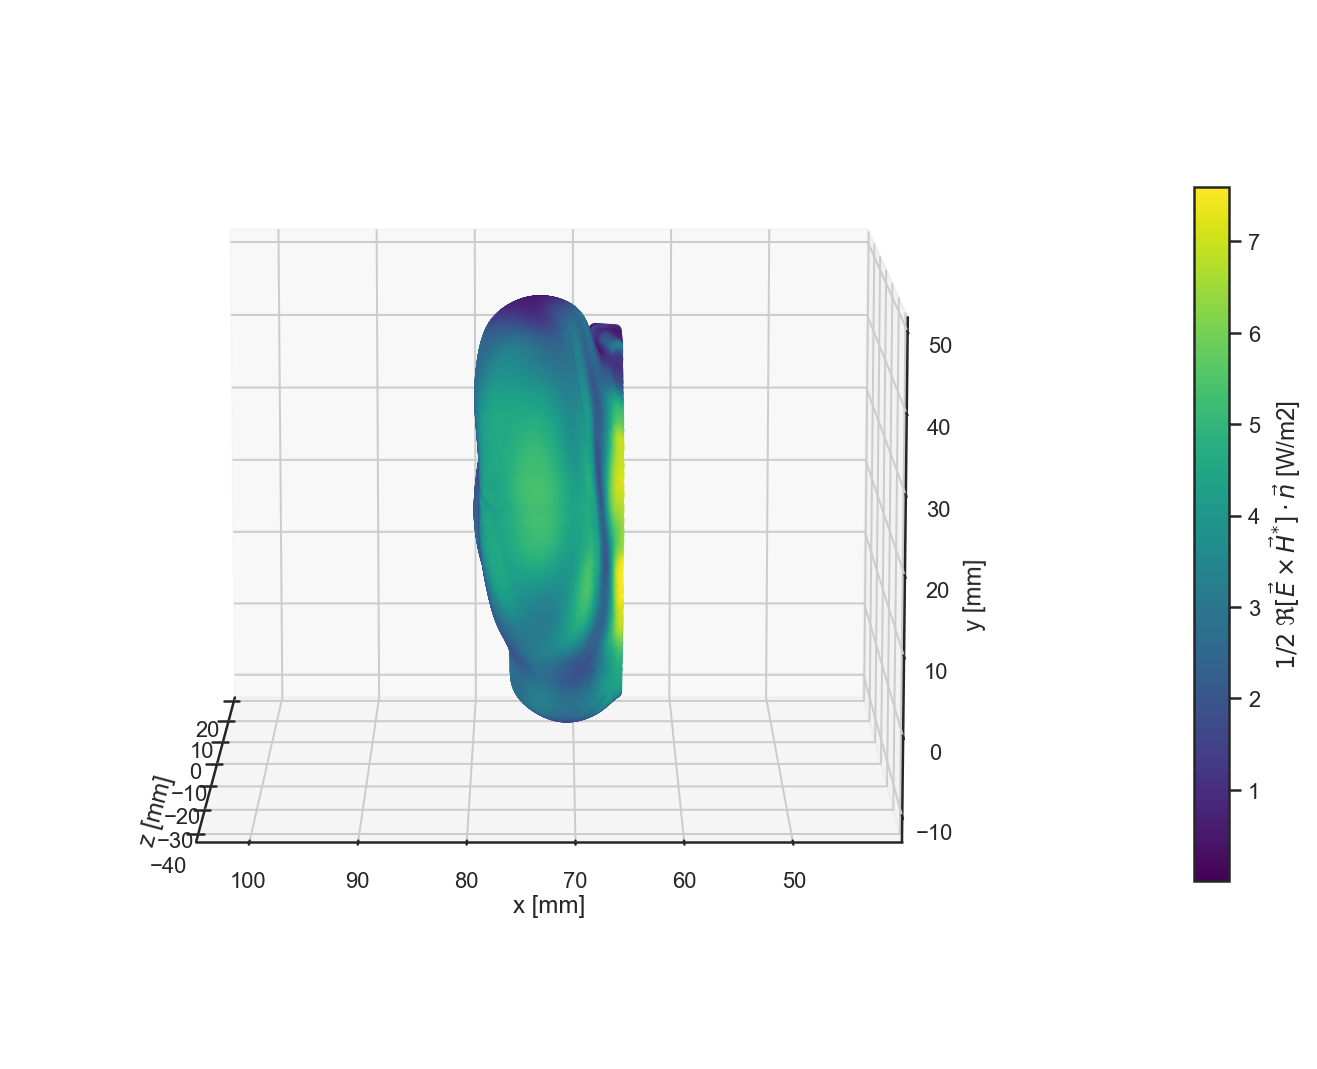

In [10]:
# removing the sharp-edged region of the model and
# visualization of the real part of the power density normal to the surface

crop_idxs = np.where(xyz[:, 0] > 65.75)[0]
xyz_crop = xyz[crop_idxs]
Sx_crop, Sy_crop, Sz_crop = Sx[crop_idxs], Sy[crop_idxs], Sz[crop_idxs]
n_crop = estimate_normals(xyz_crop, knn=300, fast=False)
Sr_crop = abs(Sx_crop.real * n_crop[:, 0]
              + Sy_crop.real * n_crop[:, 1]
              + Sz_crop.real * n_crop[:, 2])
fig, ax = scatter_3d({'z [mm]': xyz_crop[:, 2],
                      'x [mm]': xyz_crop[:, 0],
                      'y [mm]': xyz_crop[:, 1],
                      Sr_label: Sr_crop},
                     elev=[10], azim=[180], figsize=(10, 10))

In [11]:
# define coordinate frame in open3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
center = pcd.get_center()
pcd.paint_uniform_color([0.5, 0.5, 0.5])
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                           origin=center)
# o3d.visualization.draw_geometries([cframe, pcd])

In [12]:
# translate the coordinates of the model to have the center at (0, 0, 0)

xyz_t = np.c_[xyz[:, 0] - center[0],
              xyz[:, 1] - center[1],
              xyz[:, 2] - center[2]]
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(xyz_t)
center_t = pcd_t.get_center()
pcd_t.paint_uniform_color([0.5, 0.5, 0.5])
cframe_t = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                             origin=center_t)
# o3d.visualization.draw_geometries([cframe_t, pcd_t])

In [13]:
# extract the points visible from the yz-plane point of view

diameter = np.linalg.norm(pcd_t.get_max_bound() - pcd_t.get_min_bound())
radius = 10 ** 5.5
camera = [diameter, 0, 0]

_, pt_map = pcd_t.hidden_point_removal(camera, radius)

xyz_t_zy = xyz_t[pt_map]
Sr_t_zy = Sr[pt_map]
pcd_t_zy = o3d.geometry.PointCloud()
pcd_t_zy.points = o3d.utility.Vector3dVector(xyz_t_zy)
pcd_t_zy.colors = o3d.utility.Vector3dVector(colormap_from_array(Sr_t_zy))
# o3d.visualization.draw_geometries([cframe_t, pcd_t_zy])

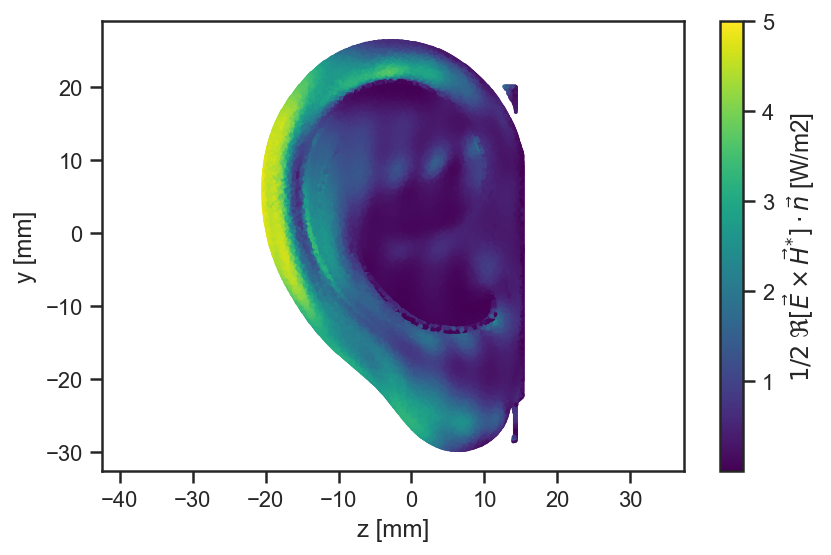

In [14]:
# visualization of the real part of the power density normal to the zy-surface

fig, ax = scatter_2d({'z [mm]': xyz_t_zy[:, 2],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy},
                     s=1);

In [15]:
# extract rectangular averaging suface area

center = [-12.5, 12.5]
edge_length = 10
origin, idx_rect = export_rect_idx(xyz=xyz_t_zy,
                                   center=center,
                                   edge_length=edge_length,
                                   view='zy')
xyz_rect = xyz_t_zy[idx_rect]
Sr_rect = Sr_t_zy[idx_rect]

APD = 1.7149051 W/m2


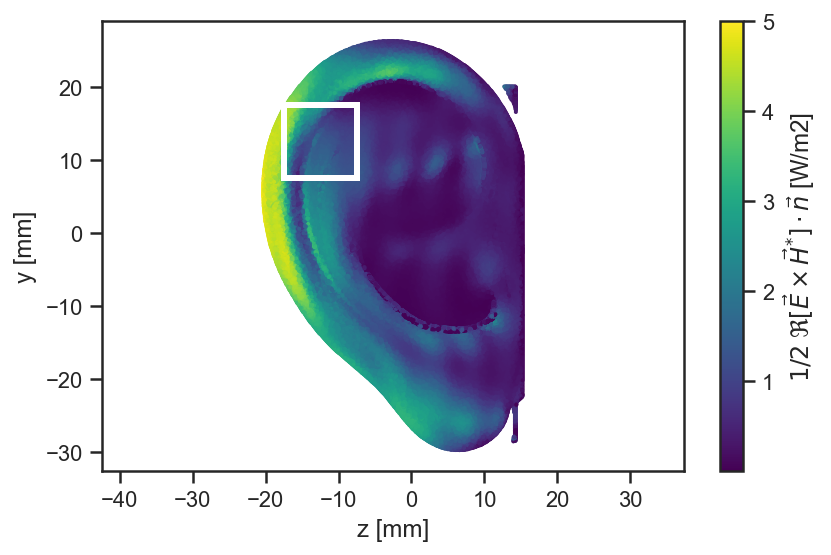

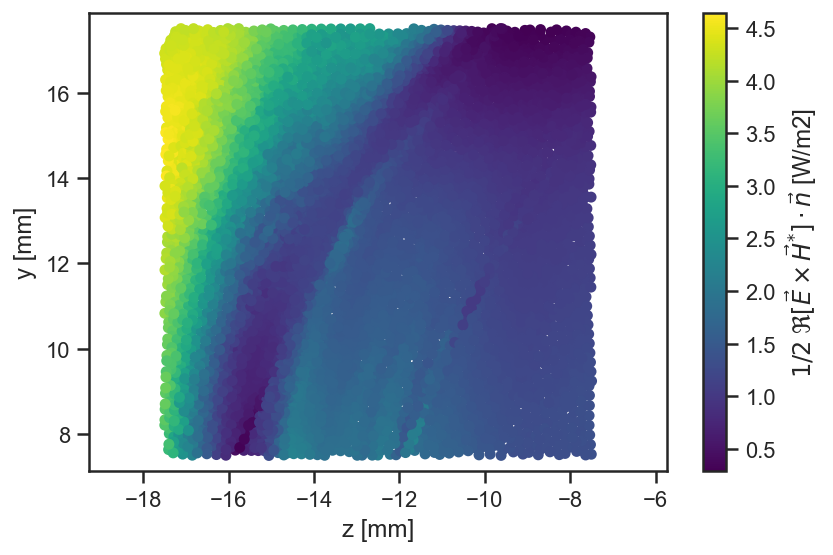

In [16]:
# visualization of the real part of the power density normal to the extracted
# rectangular averaging surface area of 1x1 cm2

fig, ax = scatter_2d({'z [mm]': xyz_t_zy[:, 2],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy}, s=1)
patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=3)
avg_surf = ax.add_patch(patch_rect);

# zoom in
fig, ax = scatter_2d({'z [mm]': xyz_rect[:, 2],
                      'y [mm]': xyz_rect[:, 1],
                      Sr_label: Sr_rect}, s=20);

# computing the average absorbed power density
area = edge_length ** 2
APD_rect = elementwise_dblquad(points=np.c_[xyz_rect[:, 2], xyz_rect[:, 1]],
                               values=Sr_rect,
                               degree=11) / area
print(f'APD = {APD_rect:.7f} W/m2')

In [17]:
# extract circular averaging suface area

radius = np.sqrt(area / np.pi)
idx_circ = export_circ_idx(xyz=xyz_t_zy,
                           center=center,
                           radius=radius,
                           view='zy')
xyz_circ = xyz_t_zy[idx_circ]
Sr_circ = Sr_t_zy[idx_circ]

APD = 1.7679418 W/m2


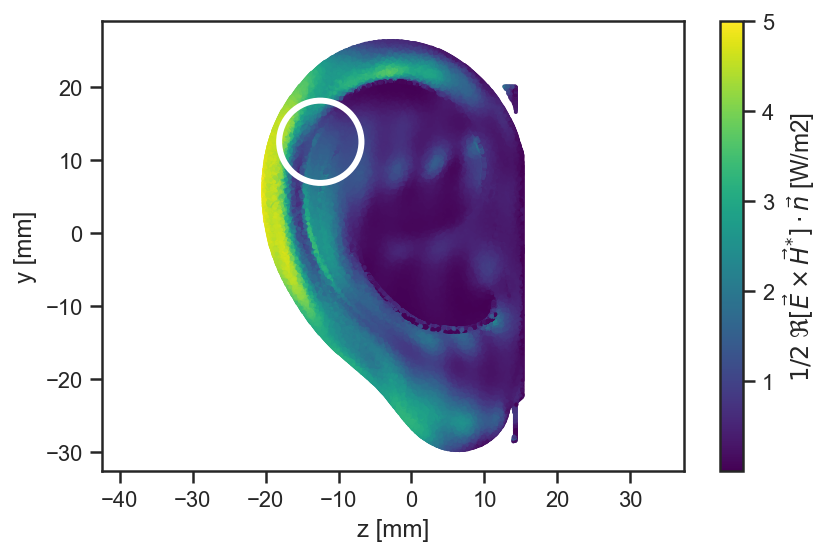

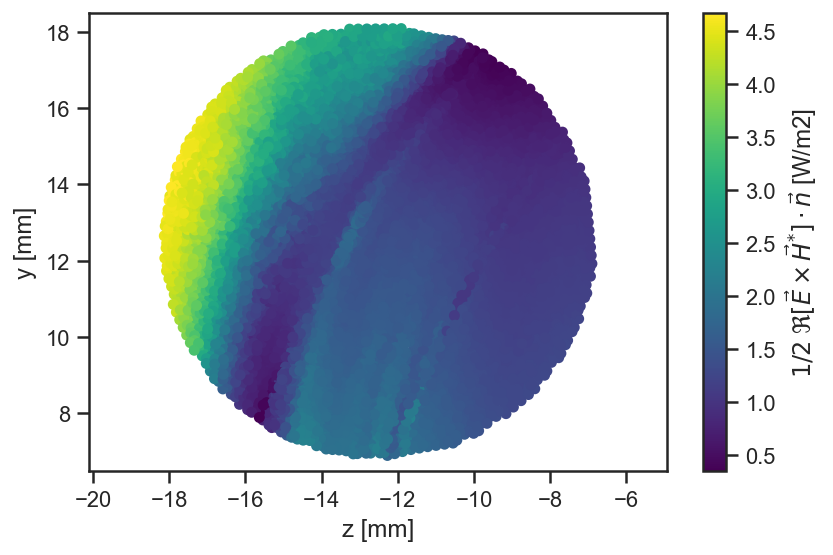

In [18]:
# visualization of the real part of the power density normal to the extracted
# circular averaging surface area of 1 cm2

fig, ax = scatter_2d({'z [mm]': xyz_t_zy[:, 2],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy}, s=1)
patch_circ = Circle(center, radius, fc='None', lw=3)
avg_surf = ax.add_patch(patch_circ);

# zoom in
fig, ax = scatter_2d({'z [mm]': xyz_circ[:, 2],
                      'y [mm]': xyz_circ[:, 1],
                      Sr_label: Sr_circ}, s=20);

# computing the average abosrbed power density
APD_circ = elementwise_circquad(points=np.c_[xyz_circ[:, 2], xyz_circ[:, 1]],
                                values=Sr_circ,
                                radius=radius,
                                center=center,
                                degree=11) / area
print(f'APD = {APD_circ:.7f} W/m2')

In [19]:
# difference in dB between absorbed power denesities computed on rectangular-
# and circular-shaped averaging surface

APD_diff = diff_in_dB(APD_rect, APD_circ)
print(f'APD_diff = {APD_diff:.7f} dB')

APD_diff = 0.1322788 dB


In [31]:
# define coordinate frame in open3d for cropped ear model

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_crop)
center = pcd.get_center()
pcd.paint_uniform_color([0.5, 0.5, 0.5])
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                           origin=center)
# o3d.visualization.draw_geometries([cframe, pcd])

In [32]:
# translate the coordinates of the model to have the center at (0, 0, 0)

xyz_crop_t = np.c_[xyz_crop[:, 0] - center[0],
              xyz_crop[:, 1] - center[1],
              xyz_crop[:, 2] - center[2]]
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(xyz_crop_t)
center_t = pcd_t.get_center()
pcd_t.paint_uniform_color([0.5, 0.5, 0.5])
cframe_t = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                             origin=center_t)
#o3d.visualization.draw_geometries([cframe_t, pcd_t])

In [33]:
# extract the points visible from the xy-plane point of view

diameter = np.linalg.norm(pcd_t.get_max_bound() - pcd_t.get_min_bound())
radius = 10 ** 5.5
camera = [0, 0, -diameter]

_, pt_map = pcd_t.hidden_point_removal(camera, radius)

xyz_t_zy = xyz_crop_t[pt_map]
Sr_t_zy = Sr_crop[pt_map]
pcd_t_zy = o3d.geometry.PointCloud()
pcd_t_zy.points = o3d.utility.Vector3dVector(xyz_t_zy)
pcd_t_zy.colors = o3d.utility.Vector3dVector(colormap_from_array(Sr_t_zy))
o3d.visualization.draw_geometries([cframe_t, pcd_t_zy])

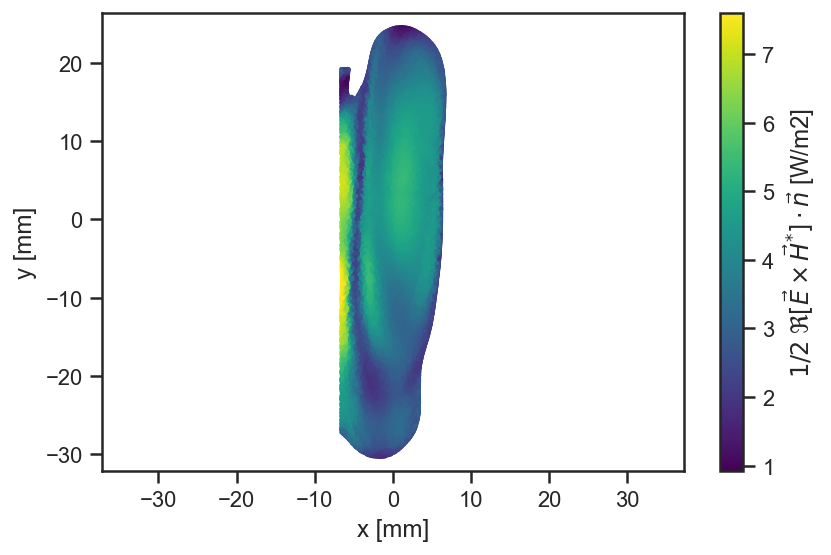

In [34]:
# visualization of the real part of the power density normal to the zy-surface

fig, ax = scatter_2d({'x [mm]': xyz_t_zy[:, 0],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy},
                     s=1);

In [35]:
# extract rectangular averaging suface area

center = [0, 0]
edge_length = 10
origin, idx_rect = export_rect_idx(xyz=xyz_t_zy,
                                   center=center,
                                   edge_length=edge_length,
                                   view='xy')
xyz_rect = xyz_t_zy[idx_rect]
Sr_rect = Sr_t_zy[idx_rect]

APD = 3.0233316 W/m2


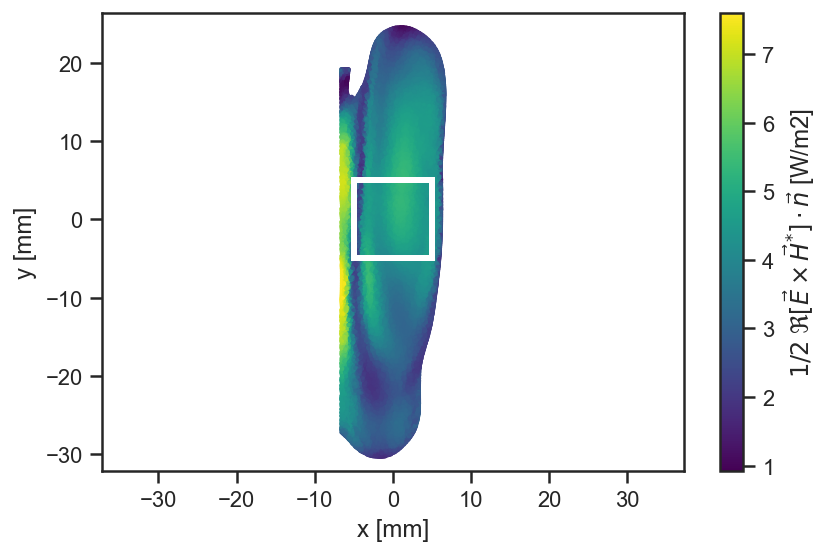

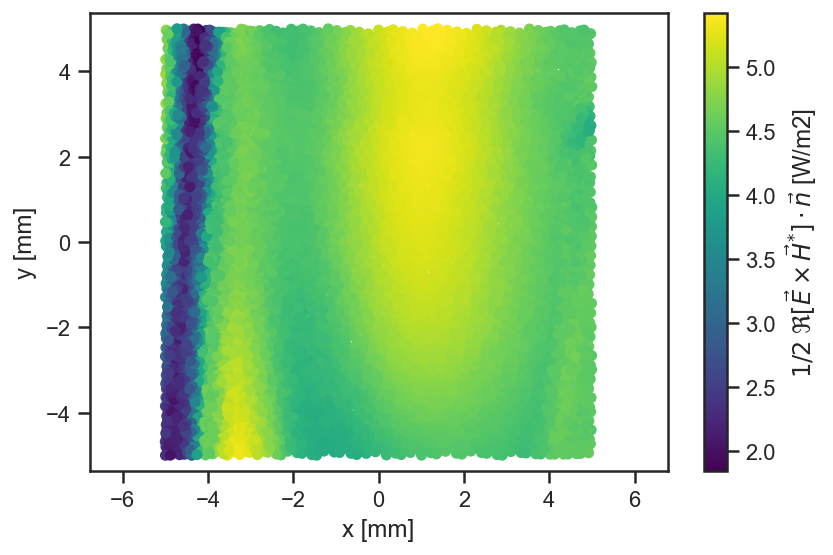

In [36]:
# visualization of the real part of the power density normal to the extracted
# rectangular averaging surface area of 1x1 cm2

fig, ax = scatter_2d({'x [mm]': xyz_t_zy[:, 0],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy}, s=1)
patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=3)
avg_surf = ax.add_patch(patch_rect);

# zoom in
fig, ax = scatter_2d({'x [mm]': xyz_rect[:, 0],
                      'y [mm]': xyz_rect[:, 1],
                      Sr_label: Sr_rect}, s=20);

# computing the average absorbed power density
area = edge_length ** 2
APD_rect = elementwise_dblquad(points=np.c_[xyz_rect[:, 2], xyz_rect[:, 1]],
                               values=Sr_rect,
                               degree=11) / area
print(f'APD = {APD_rect:.7f} W/m2')

In [37]:
# extract circular averaging suface area

radius = np.sqrt(area / np.pi)
idx_circ = export_circ_idx(xyz=xyz_t_zy,
                           center=center,
                           radius=radius,
                           view='xy')
xyz_circ = xyz_t_zy[idx_circ]
Sr_circ = Sr_t_zy[idx_circ]

APD = 4.5479751 W/m2


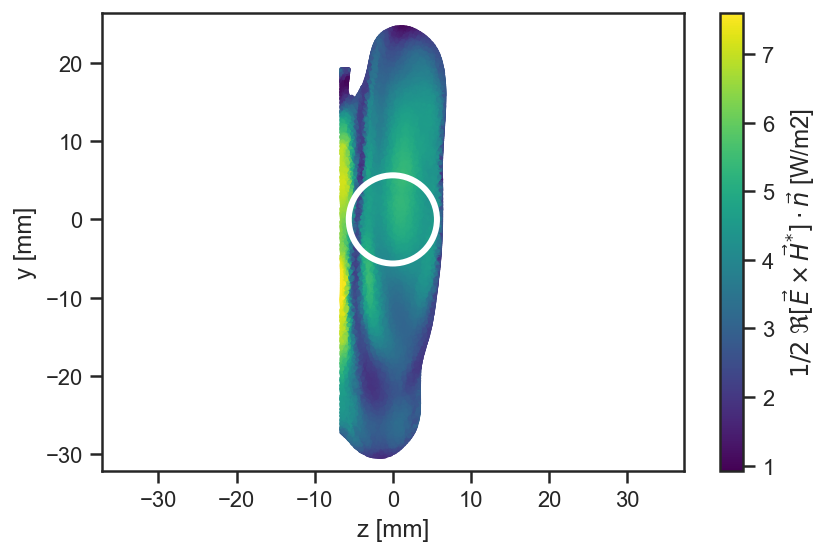

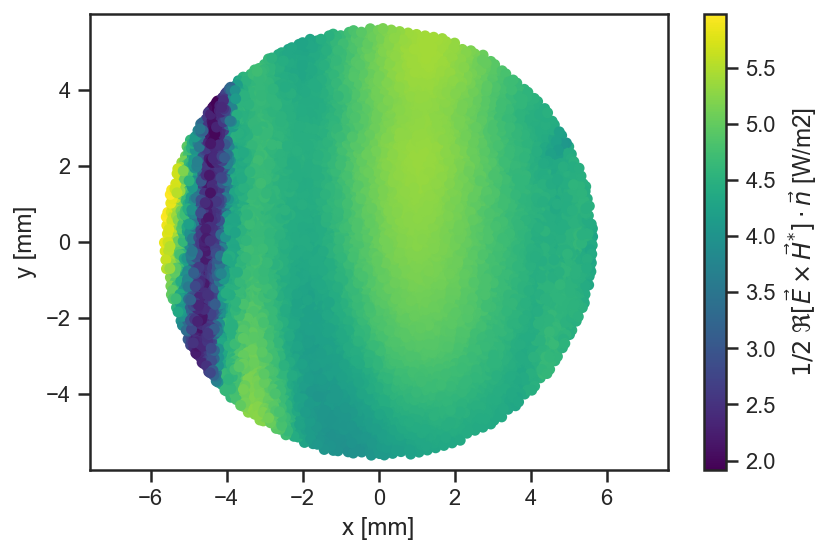

In [38]:
# visualization of the real part of the power density normal to the extracted
# circular averaging surface area of 1 cm2

fig, ax = scatter_2d({'z [mm]': xyz_t_zy[:, 0],
                      'y [mm]': xyz_t_zy[:, 1],
                      Sr_label: Sr_t_zy}, s=1)
patch_circ = Circle(center, radius, fc='None', lw=3)
avg_surf = ax.add_patch(patch_circ);

# zoom in
fig, ax = scatter_2d({'x [mm]': xyz_circ[:, 0],
                      'y [mm]': xyz_circ[:, 1],
                      Sr_label: Sr_circ}, s=20);

# computing the average abosrbed power density
APD_circ = elementwise_circquad(points=np.c_[xyz_circ[:, 0], xyz_circ[:, 1]],
                                values=Sr_circ,
                                radius=radius,
                                center=center,
                                degree=11) / area
print(f'APD = {APD_circ:.7f} W/m2')

In [39]:
# difference in dB between absorbed power denesities computed on rectangular-
# and circular-shaped averaging surface

APD_diff = diff_in_dB(APD_rect, APD_circ)
print(f'APD_diff = {APD_diff:.7f} dB')

APD_diff = 1.7733230 dB


In [41]:
# circular integration domain - set up scheme

import quadpy
scheme = quadpy.s2.get_good_scheme(12)

total_area = np.pi
flt = np.vectorize(float)
pts = flt(scheme.points.T)
weights = flt(scheme.weights.T)
radii = np.sqrt(abs(weights) / np.sum(weights) * total_area / np.pi)
colors = ['gray' if weight >= 0 else 'r' for weight in weights]

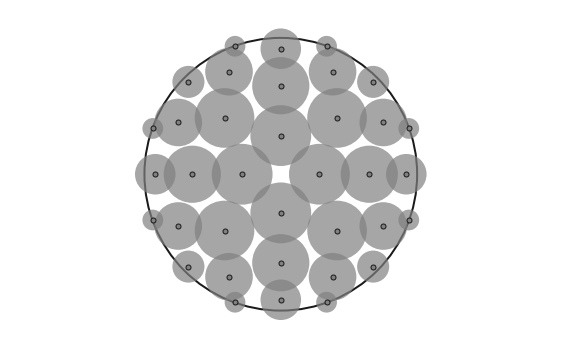

In [42]:
# visualize circular integration domain

fig_config(latex=False)
fig = plt.figure()
ax = fig.add_subplot()
ax.axis("equal")
ax.set_axis_off()
disk = plt.Circle((0, 0), 1, ec='k', fc='None')
ax.add_patch(disk)
for pt, radius, color in zip(pts, radii, colors):
    plt.plot([pt[0]], [pt[1]], linestyle="None", marker=".", color=color)
    circ = plt.Circle((pt[0], pt[1]), radius, color=color, alpha=0.7, linewidth=0)
    ax.add_patch(circ)
    
fname = os.path.join('figures', PROJECT_NAME, 'circ_int_scheme')
save_fig(fig, fname=fname)

In [47]:
# rectangular integration domain - set up scheme

deg = 6
a, b = -0.5, 0.5
x, w = np.polynomial.legendre.leggauss(deg)
x = 0.5 * (x + 1.) * (b - a) + a
w = 0.5 * w * (b - a)
Xx, Xy = np.meshgrid(x, x)
Wx, Wy = np.meshgrid(w, w)
pts = np.c_[Xx.ravel(), Xy.ravel()]
weights = np.c_[Wx.ravel(), Wy.ravel()]
weights_norm = np.linalg.norm(weights, axis=1, ord=sum(abs(x)**2)**(1./2))

total_area = 1.2
radii = np.sqrt(abs(weights_norm) / np.sum(weights_norm) * total_area / np.pi)
colors = ['gray' if weight >= 0 else 'r' for weight in weights_norm]

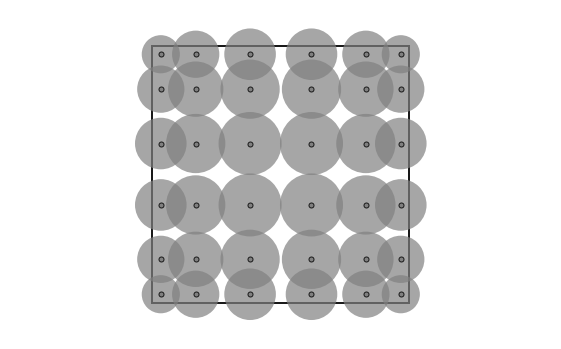

In [48]:
# visualize rectangular integration domain

fig_config(latex=False)
fig = plt.figure()
ax = fig.add_subplot()
ax.axis("equal")
ax.set_axis_off()
rect = plt.Rectangle((-0.5, -0.5), 1, 1, ec='k', fc='None')
ax.add_patch(rect)
for pt, radius, color in zip(pts, radii, colors):
    plt.plot([pt[0]], [pt[1]], linestyle="None", marker=".", color=color)
    circ = plt.Circle((pt[0], pt[1]), radius, color=color, alpha=0.7, linewidth=0)
    ax.add_patch(circ)
    
fname = os.path.join('figures', PROJECT_NAME, 'rect_int_scheme')
save_fig(fig, fname=fname)